In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import math
from statsmodels.tsa.arima_model import ARIMA
warnings.filterwarnings("ignore")   ##### ignore warnings 

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [3]:
# fix seed to make sure it is reproducible
np.random.seed(123)

# Rebuild ARIMA model

The ARCH/GARCH models will run over the based SARIMA(2,0,2) = ARMA(2,2) model from the "3.1-Model_ARMA_ARIMA_SARIMA" notebook, as it found the best performance between our tests

In [4]:
data = pd.read_csv('./data/dataset.csv', header=0, index_col=0, parse_dates=True, squeeze=True)

In [5]:
# Create Training and Test
train_data = data[:417]
test_data = data[417:]

In [6]:
# Let's fit this model
mod = ARIMA(train_data,order=(2,0,2))

results = mod.fit(trend='nc', disp=0)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 Amount   No. Observations:                  417
Model:                     ARMA(2, 2)   Log Likelihood               -4004.162
Method:                       css-mle   S.D. of innovations           3560.907
Date:                Sat, 19 Jun 2021   AIC                           8018.323
Time:                        19:17:45   BIC                           8038.488
Sample:                             0   HQIC                          8026.296
                                                                              
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
ar.L1.Amount     0.6379      0.148      4.317      0.000       0.348       0.928
ar.L2.Amount     0.3524      0.147      2.404      0.016       0.065       0.640
ma.L1.Amount     0.5901      0.144      4.105      0.000       0.308       0.872
ma.L2.Amount     0.0041      0.057      0.072      0.943      -0.107       0.116
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0072           +0.0000j            1.0072            0.0000
AR.2           -2.8174           +0.0000j            2.8174            0.5000
MA.1           -1.7149           +0.0000j            1.7149            0.5000
MA.2         -143.2392           +0.0000j          143.2392            0.5000
-----------------------------------------------------------------------------
"""

# ARCH Models

## ARCH-LM Test on the SARIMA residuals

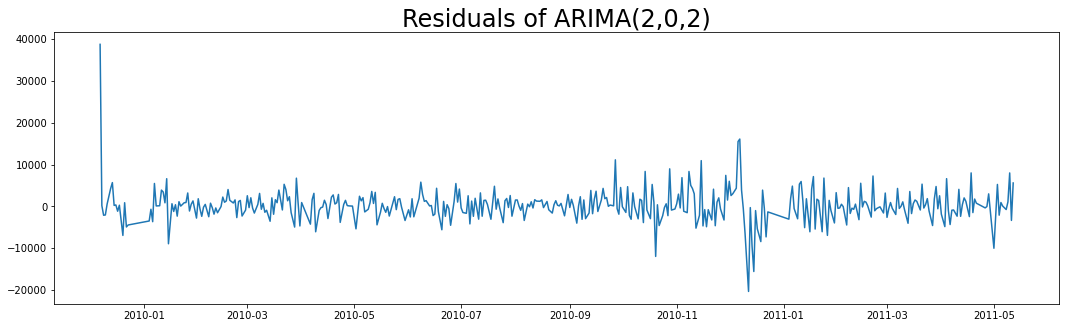

In [7]:
# Set the figure size
plt.rcParams["figure.figsize"] = 18, 5
# Plotting residuals
plt.plot(results.resid, label = "Residuals")
# Setting Title
plt.title("Residuals of ARIMA(2,0,2)", size = 24)
# Display the plot
plt.show()

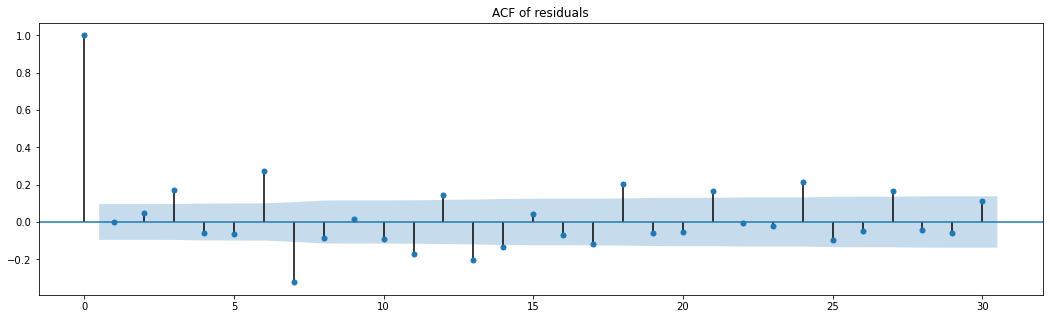

In [44]:
plot_acf(results.resid, lags=30, alpha=0.05, title="ACF of residuals")
plt.show()

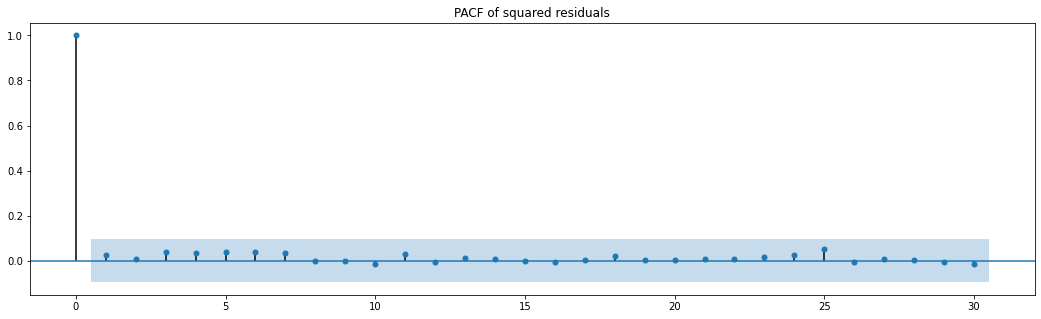

In [45]:
plot_pacf(results.resid**2, lags=30, alpha=0.05, title="PACF of squared residuals")
plt.show()

Now we will apply the LM-ARCH test in order to identify Heteroskedasticity on residuals

In [46]:
from statsmodels.stats.diagnostic import het_arch

arch_test = het_arch(results.resid, maxlag=50)

print(f'Lagrange mulitplier p-value: {arch_test[1]}')
print(f'F test p-value: {arch_test[3]}')

Lagrange mulitplier p-value: 1.8242380461778872e-07
F test p-value: 2.609695177207922e-09


Both p-value are smaller than 0.05 we reject the null hypothesis that residuals are white noise, it points to heteroskedasticity. So we will check the ARCH and GARCH modelos

## ARCH model

As the ARCH-LM test has indicated that the variance in the series is autocorrelated, it makes sense to
apply the ARCH and GARCH models, and some of their variations, to our time series of smoothed log values.

In [47]:
# Importing required package
from arch import arch_model

resid_model_arch = arch_model(results.resid, p = 1, vol = "ARCH")
# Fitting (Training) the model
resid_model_arch_results = resid_model_arch.fit()
# Displaying the model summary
resid_model_arch_results.summary()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 4007.8421467358958
Iteration:      2,   Func. Count:     10,   Neg. LLF: 4000.855241119162
Iteration:      3,   Func. Count:     14,   Neg. LLF: 4000.851727402339
Iteration:      4,   Func. Count:     18,   Neg. LLF: 4000.851654005837
Iteration:      5,   Func. Count:     22,   Neg. LLF: 4000.85164168951
Iteration:      6,   Func. Count:     26,   Neg. LLF: 4000.851570646145
Iteration:      7,   Func. Count:     30,   Neg. LLF: 4000.8512153088477
Iteration:      8,   Func. Count:     34,   Neg. LLF: 4000.849411189298
Iteration:      9,   Func. Count:     38,   Neg. LLF: 4000.8407339345554
Iteration:     10,   Func. Count:     42,   Neg. LLF: 4000.8028783087225
Iteration:     11,   Func. Count:     46,   Neg. LLF: 4000.7226278617063
Iteration:     12,   Func. Count:     50,   Neg. LLF: 4000.7212599788736
Iteration:     13,   Func. Count:     53,   Neg. LLF: 4000.7212599788627
Optimization terminated successfully    (Exit mode 0)
    

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                   None   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                       ARCH   Log-Likelihood:               -4000.72
Distribution:                  Normal   AIC:                           8007.44
Method:            Maximum Likelihood   BIC:                           8019.54
                                        No. Observations:                  417
Date:                Sat, Jun 19 2021   Df Residuals:                      414
Time:                        19:07:49   Df Model:                            3
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu           199.7831    153.643      1.300      0.193 [-1.014e+02,5.009e+02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      8.8929e+06  1.203e+06      7.394  1.425e-13 [6.536e+06,1.125e+07]
alpha[1]       0.5160      0.228      2.260  2.384e-02   [6.844e-02,  0.964]
============================================================================

Covariance estimator: robust
"""

In [48]:
arch_bic = resid_model_arch_results.bic

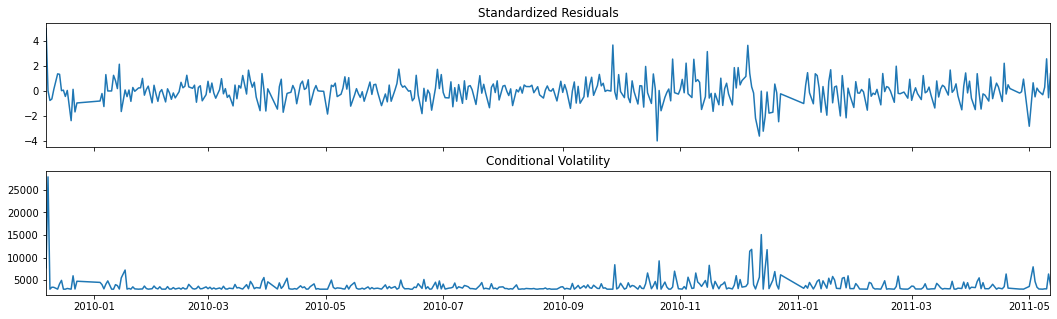

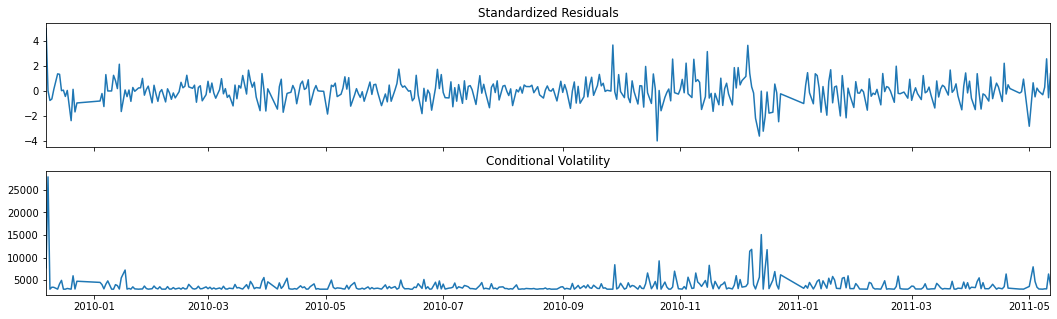

In [49]:
resid_model_arch_results.plot()

## GARCH model of order (1,1) with TStudents distribution

The GARCH(p,q) model is a generalization version of the ARCH. With a GARCH, it is possible to model the mean by including an ARMA order and also the variance (volatility), where p express the lags of conditional variance in the equation. A GARCH(0,q) model is equivalent to ARCH(q).

For the variance component, we have defined the order GARCH(1,1) as it is usually enough. Despite being a simple model, it is able to capture the most common scenarios regarding volatility (as heavy tails and clustering) and, historically, its predictions have a good performance.

In [50]:
# Importing required package
from arch import arch_model

resid_model_garch_Studentst = arch_model(results.resid, p = 1, q = 1 , vol = "GARCH", dist='StudentsT')
# Fitting (Training) the model
resid_model_garch_Studentst_results = resid_model_garch_Studentst.fit()
# Displaying the model summary
resid_model_garch_Studentst_results.summary()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 5000.675766228012
Iteration:      2,   Func. Count:     15,   Neg. LLF: 3959.4627910288996
Iteration:      3,   Func. Count:     22,   Neg. LLF: 4293.604718903651
Iteration:      4,   Func. Count:     29,   Neg. LLF: 3956.899787536189
Iteration:      5,   Func. Count:     36,   Neg. LLF: 4299.201781657858
Iteration:      6,   Func. Count:     43,   Neg. LLF: 3956.366078947318
Iteration:      7,   Func. Count:     49,   Neg. LLF: 3956.362171016167
Iteration:      8,   Func. Count:     55,   Neg. LLF: 3956.3621117904686
Iteration:      9,   Func. Count:     61,   Neg. LLF: 3956.362104834209
Iteration:     10,   Func. Count:     67,   Neg. LLF: 3956.362090448084
Iteration:     11,   Func. Count:     73,   Neg. LLF: 3956.36200956088
Iteration:     12,   Func. Count:     79,   Neg. LLF: 3956.361873738496
Iteration:     13,   Func. Count:     85,   Neg. LLF: 3956.3612276110894
Iteration:     14,   Func. Count:     91,   Neg. LLF: 3956.360

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - GARCH Model Results                         
====================================================================================
Dep. Variable:                         None   R-squared:                      -0.000
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                            GARCH   Log-Likelihood:               -3956.32
Distribution:      Standardized Student's t   AIC:                           7922.64
Method:                  Maximum Likelihood   BIC:                           7942.81
                                              No. Observations:                  417
Date:                      Sat, Jun 19 2021   Df Residuals:                      412
Time:                              19:07:59   Df Model:                            5
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu           241.2838    131.905      1.829  6.737e-02 [-17.246,4.998e+02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      3.2338e+05  1.415e+05      2.285  2.230e-02 [4.603e+04,6.007e+05]
alpha[1]       0.1060  3.339e-02      3.175  1.501e-03   [4.055e-02,  0.171]
beta[1]        0.8704  1.607e-02     54.175      0.000     [  0.839,  0.902]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             4.5370      0.947      4.792  1.651e-06 [  2.681,  6.393]
========================================================================

Covariance estimator: robust
"""

In [51]:
garch_T_bic = resid_model_garch_Studentst_results.bic

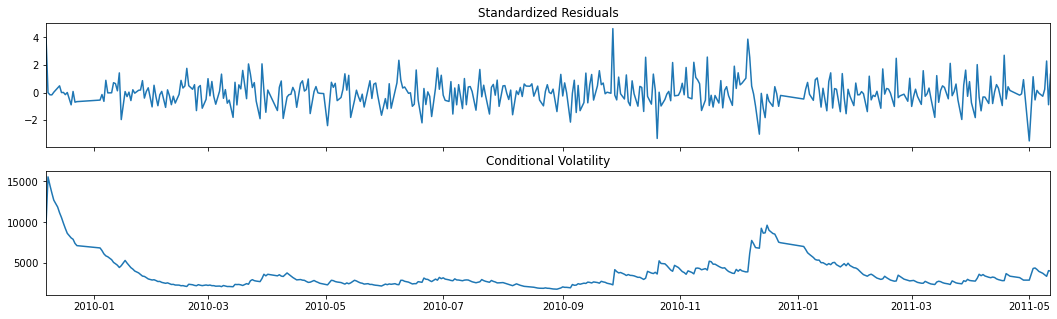

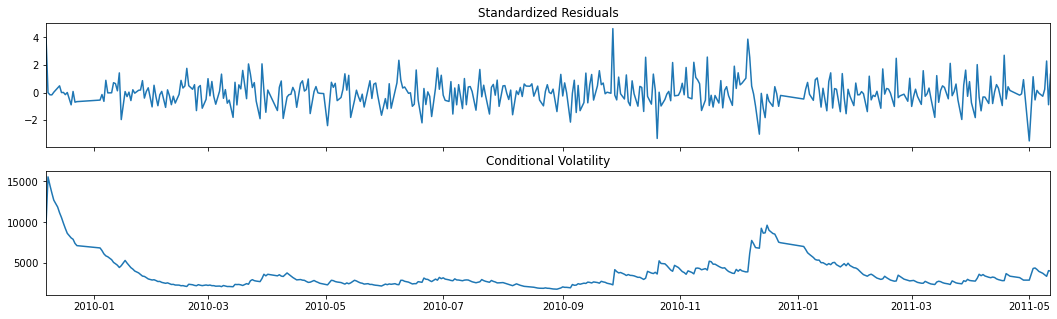

In [52]:
resid_model_garch_Studentst_results.plot()

## EGARCH model of order (1,1) with TStudents distribution

As GARCH always has an asymmetric response, due to the terms being squared based on its restrictions, it is not possible to distinguish between positive and negative shocks. This happening, the leverage impact of negative data will not be feasibly modelated. To accommodate this feature, the EGARCH model adds an asymmetry coefficient, which allows not only to keep the asymmetry but also to remove this restriction from the GARCH model.

In [53]:
# Importing required package
from arch import arch_model

resid_model_egarch_Studentst = arch_model(results.resid, p = 1, q = 1 , vol = "EGARCH", dist='StudentsT')
# Fitting (Training) the model
resid_model_egarch_Studentst_results = resid_model_egarch_Studentst.fit()
# Displaying the model summary
resid_model_egarch_Studentst_results.summary()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 6582.98815624078
Iteration:      2,   Func. Count:     13,   Neg. LLF: 6591.477445891207
Iteration:      3,   Func. Count:     21,   Neg. LLF: 164376.68455925662
Iteration:      4,   Func. Count:     35,   Neg. LLF: 5935.1055823061
Iteration:      5,   Func. Count:     43,   Neg. LLF: 4065.9392443811494
Iteration:      6,   Func. Count:     50,   Neg. LLF: 3991.092573322194
Iteration:      7,   Func. Count:     57,   Neg. LLF: 3992.0128796779695
Iteration:      8,   Func. Count:     64,   Neg. LLF: 3994.661800708809
Iteration:      9,   Func. Count:     71,   Neg. LLF: 3997.905368434723
Iteration:     10,   Func. Count:     78,   Neg. LLF: 3995.3183922084086
Iteration:     11,   Func. Count:     85,   Neg. LLF: 3975.3846789848535
Iteration:     12,   Func. Count:     92,   Neg. LLF: 3974.0151352047315
Iteration:     13,   Func. Count:     98,   Neg. LLF: 3973.2984795832563
Iteration:     14,   Func. Count:    104,   Neg. LLF: 3971.1

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - EGARCH Model Results                        
====================================================================================
Dep. Variable:                         None   R-squared:                      -0.000
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                           EGARCH   Log-Likelihood:               -3965.58
Distribution:      Standardized Student's t   AIC:                           7941.15
Method:                  Maximum Likelihood   BIC:                           7961.32
                                              No. Observations:                  417
Date:                      Sat, Jun 19 2021   Df Residuals:                      412
Time:                              19:08:06   Df Model:                            5
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu           205.6563    132.946      1.547      0.122 [-54.913,4.662e+02]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          7.3883      1.992      3.709  2.083e-04   [  3.484, 11.293]
alpha[1]       0.3150      0.145      2.176  2.959e-02 [3.121e-02,  0.599]
beta[1]        0.5535      0.119      4.668  3.044e-06   [  0.321,  0.786]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             3.3381      0.639      5.223  1.756e-07 [  2.086,  4.591]
========================================================================

Covariance estimator: robust
"""

In [54]:
egarch_T_bic = resid_model_egarch_Studentst_results.bic

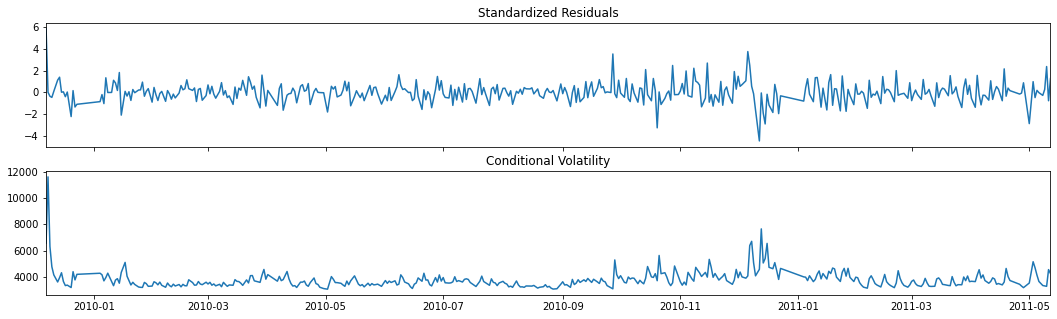

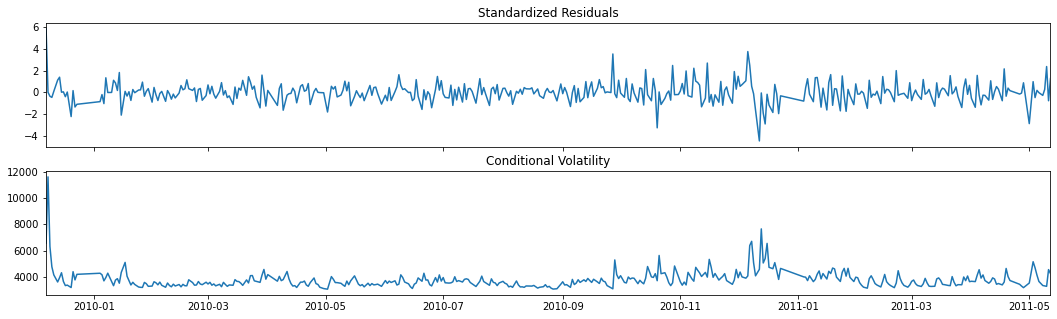

In [55]:
resid_model_egarch_Studentst_results.plot()

## GJR-GARCH model of order (1,1) with TStudents distribution

The GJR-GARCH assumes a dummy variable as an alternative to better model the negative and positive shocks. Basically, when the volatility is negative it assigns 1, otherwise 0. By doing this, negative shocks will cause more volatility than positive ones.

In [56]:
# Importing required package
from arch import arch_model

resid_model_gjrgarch_Studentst = arch_model(results.resid, p = 1, q = 1, o = 1 , vol = "GARCH", dist='StudentsT')
# Fitting (Training) the model
resid_model_gjrgarch_Studentst_results = resid_model_gjrgarch_Studentst.fit()
# Displaying the model summary
resid_model_gjrgarch_Studentst_results.summary()

Iteration:      1,   Func. Count:      8,   Neg. LLF: 4998.732058992027
Iteration:      2,   Func. Count:     17,   Neg. LLF: 3981.20704671969
Iteration:      3,   Func. Count:     25,   Neg. LLF: 3963.760621601179
Iteration:      4,   Func. Count:     33,   Neg. LLF: 4258.727105180182
Iteration:      5,   Func. Count:     41,   Neg. LLF: 3964.2750471107533
Iteration:      6,   Func. Count:     49,   Neg. LLF: 4273.350980639645
Iteration:      7,   Func. Count:     57,   Neg. LLF: 3955.940100596805
Iteration:      8,   Func. Count:     64,   Neg. LLF: 3955.886662945513
Iteration:      9,   Func. Count:     71,   Neg. LLF: 3955.879208514802
Iteration:     10,   Func. Count:     78,   Neg. LLF: 3955.8766871376747
Iteration:     11,   Func. Count:     85,   Neg. LLF: 3955.876661756498
Iteration:     12,   Func. Count:     92,   Neg. LLF: 3955.876658610928
Iteration:     13,   Func. Count:     99,   Neg. LLF: 3955.8766546589122
Iteration:     14,   Func. Count:    106,   Neg. LLF: 3955.876

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - GJR-GARCH Model Results                       
====================================================================================
Dep. Variable:                         None   R-squared:                      -0.000
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -3955.86
Distribution:      Standardized Student's t   AIC:                           7923.73
Method:                  Maximum Likelihood   BIC:                           7947.93
                                              No. Observations:                  417
Date:                      Sat, Jun 19 2021   Df Residuals:                      411
Time:                              19:08:30   Df Model:                            6
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu           257.2716    132.267      1.945  5.176e-02 [ -1.966,5.165e+02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      3.2338e+05  1.303e+05      2.481  1.309e-02 [6.794e+04,5.788e+05]
alpha[1]       0.1358  5.456e-02      2.490  1.277e-02   [2.892e-02,  0.243]
gamma[1]      -0.0673  7.796e-02     -0.864      0.388   [ -0.220,8.548e-02]
beta[1]        0.8706  1.528e-02     56.986      0.000     [  0.841,  0.901]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             4.7894      1.043      4.590  4.424e-06 [  2.744,  6.834]
========================================================================

Covariance estimator: robust
"""

In [57]:
gjrgarch_T_bic = resid_model_gjrgarch_Studentst_results.bic

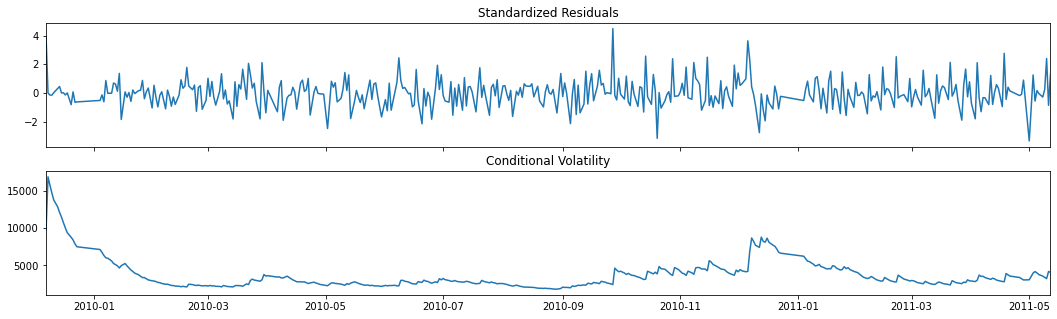

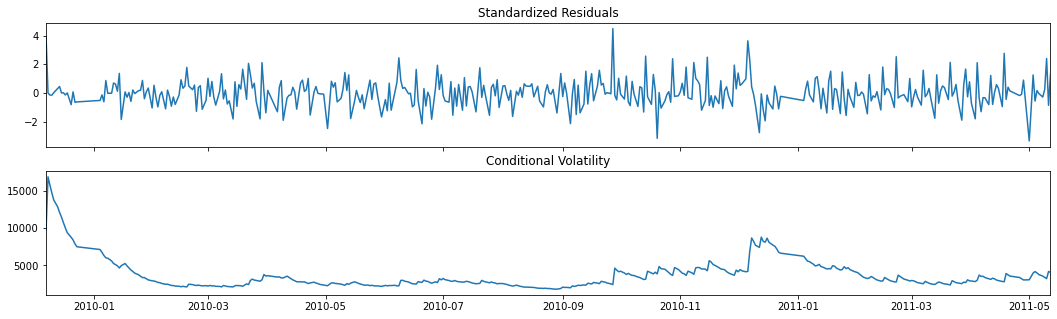

In [58]:
resid_model_gjrgarch_Studentst_results.plot()

## Comparison

In [59]:
#Compare bics and identify the smallest one
print("ARCH: ",arch_bic)
print("GARCH: ",garch_T_bic)
print("EGARCH: ",egarch_T_bic)
print("GJR-GARCH: ",gjrgarch_T_bic)

ARCH:  8019.541778623144
GARCH:  7942.807548366584
EGARCH:  7961.318242268131
GJR-GARCH:  7947.925126288348


Based on BIC the GARCH is the model that better explains the variance on residuals, although GARCH, EGARCH and GJR-GARCH had very similar results